# **LOADING DATASET**

In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Model
from keras.models import load_model

In [ ]:
# Initialize an empty list to store the image data
image_data_list = []

# Loop through the images and convert them to NumPy arrays
for i in range(31):
  # Construct the file name for the current image
  image_file = f'/content/drive/MyDrive/balloons_ms/balloons_ms/balloons_ms_{i+1:02d}.png'

  # Open the image and convert it to a NumPy array
  image = Image.open(image_file)
  image_data = np.array(image)

  # Append the image data to the list
  image_data_list.append(image_data)

# Stack the image data into a 3D array
image_data = np.stack(image_data_list, axis=2)


In [ ]:
image_data.shape

(512, 512, 31)

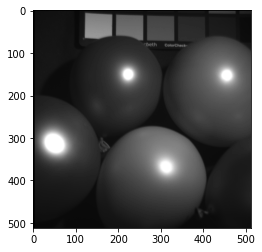

In [ ]:
plt.imshow(image_data[:,:,1],cmap='gray')

# **GROUND TRUTH DATASET GENERATION AND DISPLAY**

**creating patches**

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

gt_data=[]

for j in range(8):

  for i in range(8):
    if j==0 & i==0:
      gt_dataset=image_data[0:63,0:63,0:31]

  # Extract a ROI from the image
    gt_dataset=image_data[j*64:j*64+64,i*64:i*64+64,0:31]
    gt_data.append(gt_dataset)
# Stack the image data into a 3D array
gt_dataset = np.stack(gt_data, axis=2)

(64, 64, 64, 31)


<function matplotlib.pyplot.show(*args, **kw)>

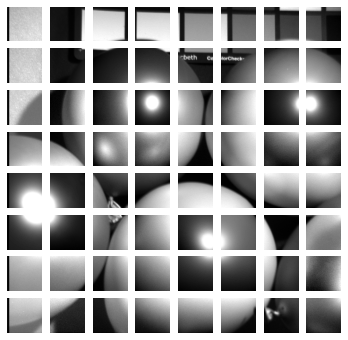

In [ ]:
patches=np.asarray(gt_data)
print(patches.shape)
plt.figure(figsize=(6,6))
for i in range(64):
  plt.subplot(8,8,i+1)
  plt.imshow(patches[i,:,:,1],cmap='gray')
  plt.axis('off')
plt.show

In [ ]:
gt_dataset.shape

(64, 64, 64, 31)

In [ ]:
image_transposed = np.transpose(gt_dataset, (2, 0, 1, 3))

In [ ]:
image_transposed.shape

(64, 64, 64, 31)

# **GENERATION OF HIGH RESOLUTION RGB DATASET**

In [ ]:
# Define the input layer
input_layer = layers.Input(shape=(64, 64, 31))

# Define the convolutional layer
conv_layer = layers.Conv2D(3, kernel_size=3, padding='same', activation='relu')(input_layer)

# Define the model
model = tf.keras.Model(input_layer, conv_layer)

# Compile the model
HR_RGB = model.predict(image_transposed)

2/2 [==============================] - 7s 15ms/step


In [ ]:
HR_RGB.shape

# **GENERATION LOW RESOLUTION HYPER-SPECTRAL DATASET**

In [ ]:
# Define the input layer
input_layer = layers.Input(shape=(64, 64, 31))

# Define the convolutional layer
conv_layer = layers.Conv2D(31, kernel_size=3, strides=8, padding='same', activation='relu')(input_layer)

# Define the model
model = tf.keras.Model(input_layer, conv_layer)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')
LRHSI = model.predict(image_transposed)

2/2 [==============================] - 0s 9ms/step


In [ ]:
LRHSI.shape

(64, 8, 8, 31)

# **CNN MODEL FOR SUPER RESOLUTION**

**CNN MODEL: 1**

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

# Define the input layers
input_layer1 = layers.Input(shape=(64, 64, 3))
input_layer2 = layers.Input(shape=(8, 8, 31))
upsample1 = layers.UpSampling2D(size=1)(input_layer1)
conv_layer1 = layers.Conv2D(31, kernel_size=1, activation='relu')(upsample1)
upsample = layers.UpSampling2D(size=8)(input_layer2)
conv_layer2 = layers.Conv2D(31, kernel_size=1, activation='relu')(upsample)
output_layer = layers.Add()([conv_layer1, conv_layer2 ])

# Define the model
model = tf.keras.Model([input_layer1, input_layer2], output_layer)
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mean_absolute_error', metrics=['accuracy'])


In [ ]:
history = model.fit([HR_RGB, LRHSI], image_transposed, epochs=1000, batch_size=32, validation_split=0.2)

Epoch 1/1000
2/2 [==============================] - 0s 67ms/step - loss: 939.0837 - accuracy: 0.6533 - val_loss: 430.1818 - val_accuracy: 0.6506
Epoch 2/1000
2/2 [==============================] - 0s 38ms/step - loss: 937.0073 - accuracy: 0.6577 - val_loss: 432.3118 - val_accuracy: 0.6503
Epoch 3/1000
2/2 [==============================] - 0s 37ms/step - loss: 938.8234 - accuracy: 0.6646 - val_loss: 431.2275 - val_accuracy: 0.6594
Epoch 4/1000
2/2 [==============================] - 0s 34ms/step - loss: 940.7975 - accuracy: 0.6591 - val_loss: 433.4122 - val_accuracy: 0.6545
Epoch 5/1000
2/2 [==============================] - 0s 38ms/step - loss: 936.0226 - accuracy: 0.6749 - val_loss: 432.2160 - val_accuracy: 0.6564
Epoch 6/1000
2/2 [==============================] - 0s 36ms/step - loss: 943.3903 - accuracy: 0.6197 - val_loss: 431.1127 - val_accuracy: 0.6541
Epoch 7/1000
2/2 [==============================] - 0s 46ms/step - loss: 938.3116 - accuracy: 0.6822 - val_loss: 430.1499 - val_ac

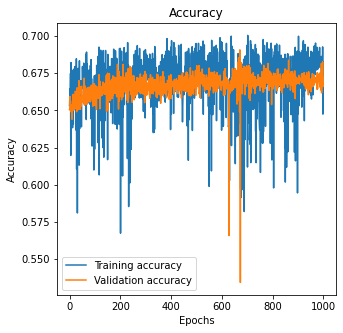

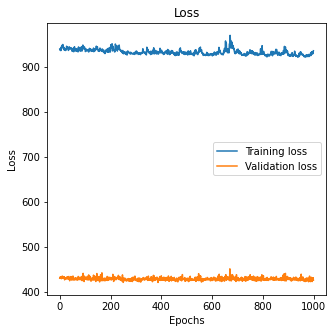

In [ ]:
# Extract the accuracy and loss values from the history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the first graph in the first subplot
fig = plt.figure(figsize=(5, 5))
plt.plot(acc, label='Training accuracy')
plt.plot(val_acc, label='Validation accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot the second graph in the second subplot
fig = plt.figure(figsize=(5, 5))
plt.plot(loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

2/2 [==============================] - 0s 5ms/step
(64, 64, 64, 31)
(64, 64, 64, 31)


<function matplotlib.pyplot.show(*args, **kw)>

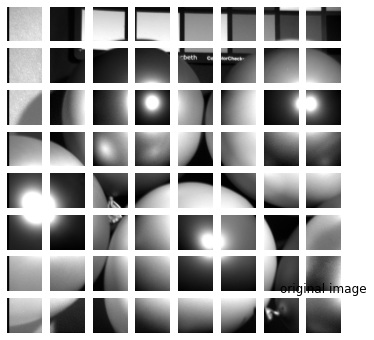

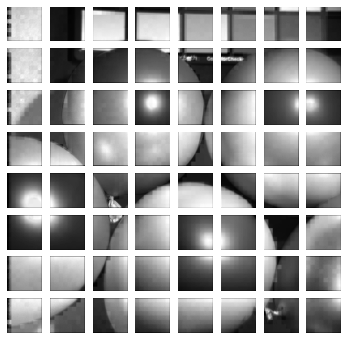

In [ ]:
out1=model.predict([HR_RGB,LRHSI])
patches=np.asarray(gt_data)
print(patches.shape)
plt.figure(figsize=(6,6))
for i in range(64):
  plt.subplot(8,8,i+1)
  plt.imshow(patches[i,:,:,1],cmap='gray')
  plt.axis('off')
plt.show

patches=np.asarray(out1)
print(patches.shape)
plt.figure(figsize=(6,6))
for i in range(64):
  plt.subplot(8,8,i+1)
  plt.imshow(patches[i,:,:,1],cmap='gray')
  plt.axis('off')
plt.show


**CNN MODEL:2**

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
# Define the input layers
input_layer1 = layers.Input(shape=(64, 64, 3))
input_layer2 = layers.Input(shape=(8, 8, 31))
upsample1 = layers.UpSampling2D(size=1)(input_layer1)
conv_layer1 = layers.Conv2D(31, kernel_size=1, activation='relu')(upsample1)
upsample = layers.UpSampling2D(size=8)(input_layer2)
conv_layer2 = layers.Conv2D(31, kernel_size=1, activation='relu')(upsample)
output_layer1 = layers.Add()([conv_layer1, conv_layer2 ])
conv_layer3 = layers.Conv2D(64, kernel_size=1, activation='relu')(output_layer1)
pooling_layer2 = layers.MaxPooling2D(pool_size=(1, 1))(conv_layer3)
conv_layer4 = layers.Conv2D(128, kernel_size=1, activation='relu')(pooling_layer2)
pooling_layer3 = layers.MaxPooling2D(pool_size=(1, 1))(conv_layer4)
conv_layer5 = layers.Conv2D(64, kernel_size=1, activation='relu')(pooling_layer3)
pooling_layer4 = layers.MaxPooling2D(pool_size=(1, 1))(conv_layer5)
output_layer = layers.Conv2D(31, kernel_size=1, activation='relu')(pooling_layer4)
model = tf.keras.Model([input_layer1, input_layer2], output_layer)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mean_absolute_error', metrics=['accuracy'])
history = model.fit([HR_RGB, LRHSI], image_transposed, epochs=1000, batch_size=32, validation_split=0.2)

Epoch 1/1000
2/2 [==============================] - 1s 469ms/step - loss: 9068.7129 - accuracy: 0.0492 - val_loss: 2907.0469 - val_accuracy: 3.7560e-05
Epoch 2/1000
2/2 [==============================] - 0s 46ms/step - loss: 7187.8501 - accuracy: 0.0014 - val_loss: 2475.5164 - val_accuracy: 0.1432
Epoch 3/1000
2/2 [==============================] - 0s 46ms/step - loss: 6679.3589 - accuracy: 0.0035 - val_loss: 2652.1848 - val_accuracy: 0.0073
Epoch 4/1000
2/2 [==============================] - 0s 50ms/step - loss: 6249.6074 - accuracy: 0.0030 - val_loss: 2549.2476 - val_accuracy: 0.0000e+00
Epoch 5/1000
2/2 [==============================] - 0s 49ms/step - loss: 5977.2617 - accuracy: 0.0124 - val_loss: 2480.4858 - val_accuracy: 0.0072
Epoch 6/1000
2/2 [==============================] - 0s 48ms/step - loss: 5528.8711 - accuracy: 0.0039 - val_loss: 2260.9260 - val_accuracy: 0.0075
Epoch 7/1000
2/2 [==============================] - 0s 48ms/step - loss: 5009.8633 - accuracy: 0.0114 - val_l

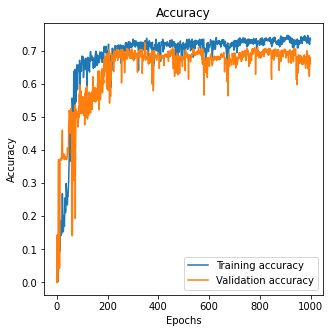

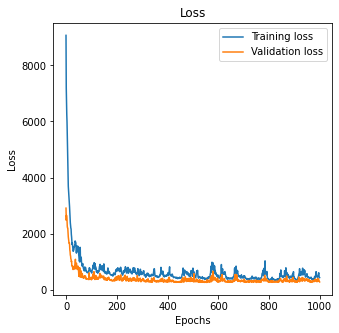

In [ ]:
# Extract the accuracy and loss values from the history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the first graph in the first subplot
fig = plt.figure(figsize=(5, 5))
plt.plot(acc, label='Training accuracy')
plt.plot(val_acc, label='Validation accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot the second graph in the second subplot
fig = plt.figure(figsize=(5, 5))
plt.plot(loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

2/2 [==============================] - 0s 9ms/step
(64, 64, 64, 31)
(64, 64, 64, 31)


<function matplotlib.pyplot.show(*args, **kw)>

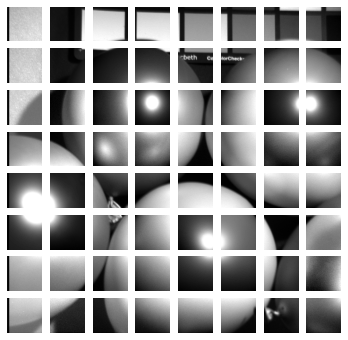

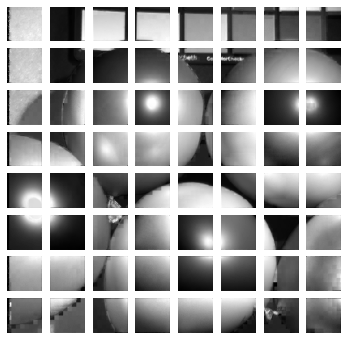

In [ ]:
out2=model.predict([HR_RGB,LRHSI])
patches=np.asarray(gt_data)
print(patches.shape)
plt.figure(figsize=(6,6))
for i in range(64):
  plt.subplot(8,8,i+1)
  plt.imshow(patches[i,:,:,1],cmap='gray')
  plt.axis('off')
plt.show

patches=np.asarray(out2)
print(patches.shape)
plt.figure(figsize=(6,6))
for i in range(64):
  plt.subplot(8,8,i+1)
  plt.imshow(patches[i,:,:,1],cmap='gray')
  plt.axis('off')
plt.show


**CHANGED OPTIMIZER FUNCtion**

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
# Define the input layers
input_layer1 = layers.Input(shape=(64, 64, 3))
input_layer2 = layers.Input(shape=(8, 8, 31))
upsample1 = layers.UpSampling2D(size=1)(input_layer1)
conv_layer1 = layers.Conv2D(31, kernel_size=1, activation='relu')(upsample1)
upsample = layers.UpSampling2D(size=8)(input_layer2)
conv_layer2 = layers.Conv2D(31, kernel_size=1, activation='relu')(upsample)
output_layer1 = layers.Add()([conv_layer1, conv_layer2 ])
conv_layer3 = layers.Conv2D(64, kernel_size=1, activation='relu')(output_layer1)
pooling_layer2 = layers.MaxPooling2D(pool_size=(1, 1))(conv_layer3)
conv_layer4 = layers.Conv2D(128, kernel_size=1, activation='relu')(pooling_layer2)
pooling_layer3 = layers.MaxPooling2D(pool_size=(1, 1))(conv_layer4)
conv_layer5 = layers.Conv2D(64, kernel_size=1, activation='relu')(pooling_layer3)
pooling_layer4 = layers.MaxPooling2D(pool_size=(1, 1))(conv_layer5)
output_layer = layers.Conv2D(31, kernel_size=1, activation='relu')(pooling_layer4)
model = tf.keras.Model([input_layer1, input_layer2], output_layer)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.01), loss='mean_absolute_error', metrics=['accuracy'])
history = model.fit([HR_RGB, LRHSI], image_transposed, epochs=1000, batch_size=32, validation_split=0.2)

Epoch 1/1000
2/2 [==============================] - 1s 205ms/step - loss: 23155.1621 - accuracy: 0.0140 - val_loss: 3801.8948 - val_accuracy: 1.6902e-04
Epoch 2/1000
2/2 [==============================] - 0s 56ms/step - loss: 8389.0303 - accuracy: 0.0471 - val_loss: 3480.0535 - val_accuracy: 1.6902e-04
Epoch 3/1000
2/2 [==============================] - 0s 58ms/step - loss: 6714.7524 - accuracy: 0.0580 - val_loss: 2559.3518 - val_accuracy: 1.6902e-04
Epoch 4/1000
2/2 [==============================] - 0s 52ms/step - loss: 5330.3989 - accuracy: 0.0187 - val_loss: 3135.8567 - val_accuracy: 1.8780e-05
Epoch 5/1000
2/2 [==============================] - 0s 52ms/step - loss: 7178.5376 - accuracy: 0.0020 - val_loss: 2528.4878 - val_accuracy: 3.7560e-05
Epoch 6/1000
2/2 [==============================] - 0s 48ms/step - loss: 4899.8169 - accuracy: 0.0070 - val_loss: 2342.8364 - val_accuracy: 5.8218e-04
Epoch 7/1000
2/2 [==============================] - 0s 51ms/step - loss: 4727.5898 - accurac

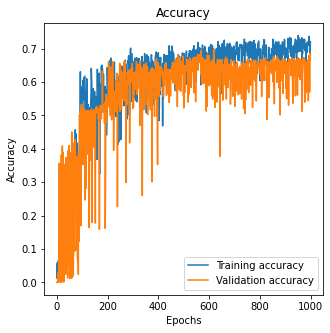

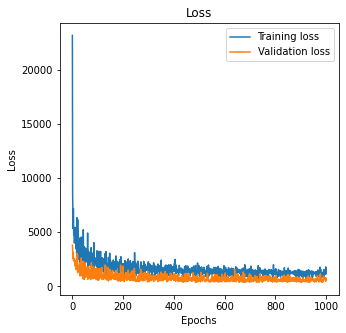

In [ ]:
# Extract the accuracy and loss values from the history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the first graph in the first subplot
fig = plt.figure(figsize=(5, 5))
plt.plot(acc, label='Training accuracy')
plt.plot(val_acc, label='Validation accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot the second graph in the second subplot
fig = plt.figure(figsize=(5, 5))
plt.plot(loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

2/2 [==============================] - 0s 10ms/step
(64, 64, 64, 31)
(64, 64, 64, 31)


<function matplotlib.pyplot.show(*args, **kw)>

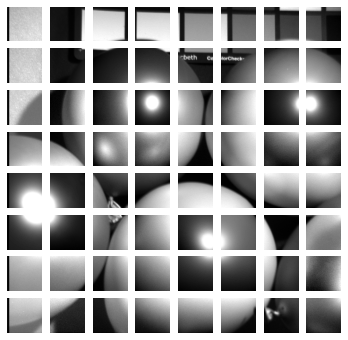

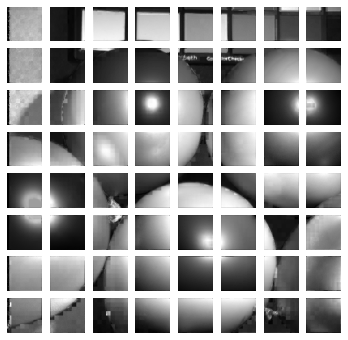

In [ ]:
out3=model.predict([HR_RGB,LRHSI])
patches=np.asarray(gt_data)
print(patches.shape)
plt.figure(figsize=(6,6))
for i in range(64):
  plt.subplot(8,8,i+1)
  plt.imshow(patches[i,:,:,1],cmap='gray')
  plt.axis('off')
plt.show

patches=np.asarray(out3)
print(patches.shape)
plt.figure(figsize=(6,6))
for i in range(64):
  plt.subplot(8,8,i+1)
  plt.imshow(patches[i,:,:,1],cmap='gray')
  plt.axis('off')
plt.show


**changed activation function**

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
# Define the input layers
input_layer1 = layers.Input(shape=(64, 64, 3))
input_layer2 = layers.Input(shape=(8, 8, 31))
upsample1 = layers.UpSampling2D(size=1)(input_layer1)
conv_layer1 = layers.Conv2D(31, kernel_size=1, activation='LeakyReLU')(upsample1)
upsample = layers.UpSampling2D(size=8)(input_layer2)
conv_layer2 = layers.Conv2D(31, kernel_size=1, activation='LeakyReLU')(upsample)
output_layer1 = layers.Add()([conv_layer1, conv_layer2 ])
conv_layer3 = layers.Conv2D(64, kernel_size=1, activation='LeakyReLU')(output_layer1)
pooling_layer2 = layers.MaxPooling2D(pool_size=(1, 1))(conv_layer3)
conv_layer4 = layers.Conv2D(128, kernel_size=1, activation='LeakyReLU')(pooling_layer2)
pooling_layer3 = layers.MaxPooling2D(pool_size=(1, 1))(conv_layer4)
conv_layer5 = layers.Conv2D(64, kernel_size=1, activation='LeakyReLU')(pooling_layer3)
pooling_layer4 = layers.MaxPooling2D(pool_size=(1, 1))(conv_layer5)
output_layer = layers.Conv2D(31, kernel_size=1, activation='LeakyReLU')(pooling_layer4)
model = tf.keras.Model([input_layer1, input_layer2], output_layer)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.01), loss='mean_squared_error', metrics=['accuracy'])
history = model.fit([HR_RGB, LRHSI], image_transposed, epochs=1000, batch_size=32, validation_split=0.2)

Epoch 1/1000
2/2 [==============================] - 1s 211ms/step - loss: 210652320.0000 - accuracy: 0.0043 - val_loss: 58891384.0000 - val_accuracy: 0.0240
Epoch 2/1000
2/2 [==============================] - 0s 58ms/step - loss: 248115360.0000 - accuracy: 0.0569 - val_loss: 26717032.0000 - val_accuracy: 9.3900e-05
Epoch 3/1000
2/2 [==============================] - 0s 71ms/step - loss: 390929216.0000 - accuracy: 0.0662 - val_loss: 18748510.0000 - val_accuracy: 0.3701
Epoch 4/1000
2/2 [==============================] - 0s 54ms/step - loss: 95317352.0000 - accuracy: 0.1416 - val_loss: 14495636.0000 - val_accuracy: 0.0026
Epoch 5/1000
2/2 [==============================] - 0s 67ms/step - loss: 83828944.0000 - accuracy: 0.0094 - val_loss: 17810136.0000 - val_accuracy: 0.0959
Epoch 6/1000
2/2 [==============================] - 0s 51ms/step - loss: 98337328.0000 - accuracy: 0.0787 - val_loss: 7733749.0000 - val_accuracy: 0.3686
Epoch 7/1000
2/2 [==============================] - 0s 53ms/ste

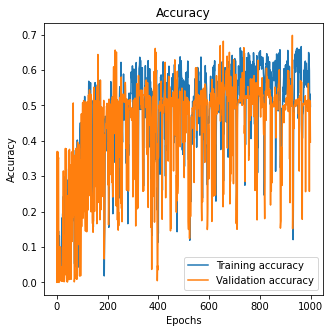

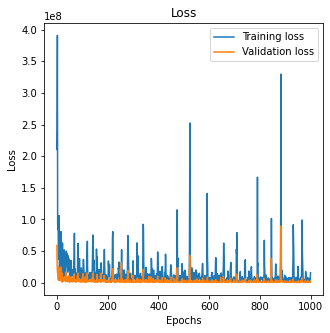

In [ ]:
# Extract the accuracy and loss values from the history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the first graph in the first subplot
fig = plt.figure(figsize=(5, 5))
plt.plot(acc, label='Training accuracy')
plt.plot(val_acc, label='Validation accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot the second graph in the second subplot
fig = plt.figure(figsize=(5, 5))
plt.plot(loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

2/2 [==============================] - 0s 8ms/step
(64, 64, 64, 31)
(64, 64, 64, 31)


<function matplotlib.pyplot.show(*args, **kw)>

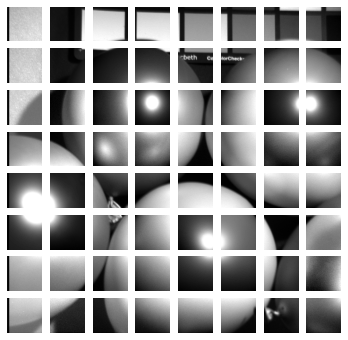

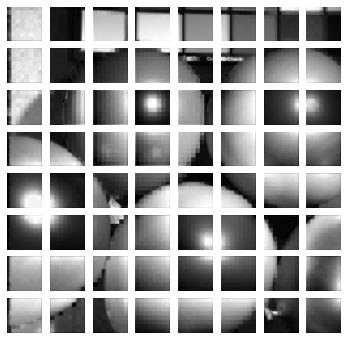

In [ ]:
out4=model.predict([HR_RGB,LRHSI])
patches=np.asarray(gt_data)
print(patches.shape)
plt.figure(figsize=(6,6))
for i in range(64):
  plt.subplot(8,8,i+1)
  plt.imshow(patches[i,:,:,1],cmap='gray')
  plt.axis('off')
plt.show

patches=np.asarray(out4)
print(patches.shape)
plt.figure(figsize=(6,6))
for i in range(64):
  plt.subplot(8,8,i+1)
  plt.imshow(patches[i,:,:,1],cmap='gray')
  plt.axis('off')
plt.show


**CNN 3**

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

# Define the input layers
input_layer1 = layers.Input(shape=(64, 64, 3))
input_layer2 = layers.Input(shape=(8, 8, 31))
upsampled = layers.UpSampling2D(size=8)(input_layer2)
combined = layers.Conv2D(31, kernel_size=1, activation='relu')(upsampled)
conv1 = layers.Conv2D(64, kernel_size=1, activation='relu')(combined)
pool1 = layers.MaxPooling2D(pool_size=(1, 1))(conv1)
conv2 = layers.Conv2D(128, kernel_size=1, activation='relu')(pool1)
pool2 = layers.MaxPooling2D(pool_size=(1, 1))(conv2)
conv3 = layers.Conv2D(64, kernel_size=1, activation='relu')(pool2)
pool3 = layers.MaxPooling2D(pool_size=(1, 1))(conv3)
output_layer = layers.Conv2D(31, kernel_size=1, activation='relu')(pool3)
modelnew = tf.keras.Model([input_layer1, input_layer2], output_layer)

# Compile the model
modelnew.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mean_absolute_error', metrics=['accuracy'])
history = modelnew.fit([HR_RGB, LRHSI], image_transposed, epochs=1000, batch_size=32, validation_split=0.2)

Epoch 1/1000
2/2 [==============================] - 0s 87ms/step - loss: 120802144.0000 - accuracy: 0.4412 - val_loss: 6113418.5000 - val_accuracy: 0.3055
Epoch 2/1000
2/2 [==============================] - 0s 52ms/step - loss: 24470422.0000 - accuracy: 0.4441 - val_loss: 1698012.0000 - val_accuracy: 0.5156
Epoch 3/1000
2/2 [==============================] - 0s 54ms/step - loss: 5768275.5000 - accuracy: 0.5341 - val_loss: 1116654.0000 - val_accuracy: 0.5153
Epoch 4/1000
2/2 [==============================] - 0s 52ms/step - loss: 3447679.0000 - accuracy: 0.5403 - val_loss: 824910.8750 - val_accuracy: 0.5232
Epoch 5/1000
2/2 [==============================] - 0s 51ms/step - loss: 2873707.0000 - accuracy: 0.5657 - val_loss: 724137.0625 - val_accuracy: 0.5175
Epoch 6/1000
2/2 [==============================] - 0s 55ms/step - loss: 2438649.0000 - accuracy: 0.6343 - val_loss: 561928.0625 - val_accuracy: 0.5270
Epoch 7/1000
2/2 [==============================] - 0s 51ms/step - loss: 2226108.2

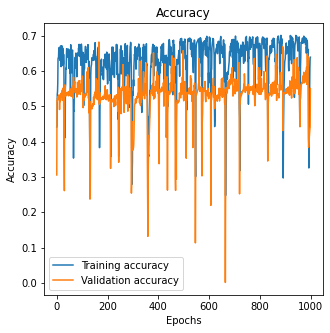

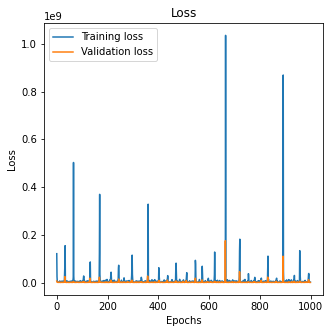

In [ ]:
# Extract the accuracy and loss values from the history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the first graph in the first subplot
fig = plt.figure(figsize=(5, 5))
plt.plot(acc, label='Training accuracy')
plt.plot(val_acc, label='Validation accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot the second graph in the second subplot
fig = plt.figure(figsize=(5, 5))
plt.plot(loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

2/2 [==============================] - 0s 12ms/step
(64, 64, 64, 31)
(64, 64, 64, 31)


<function matplotlib.pyplot.show(*args, **kw)>

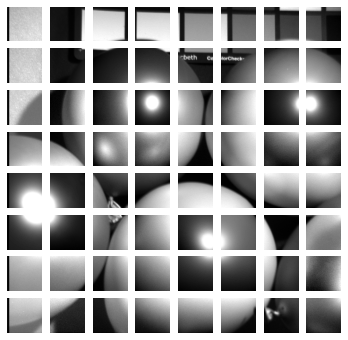

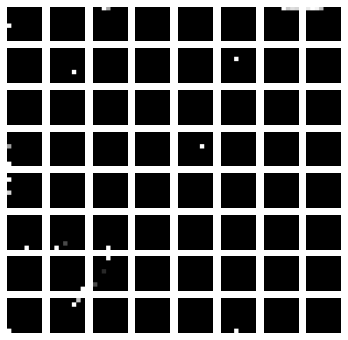

In [ ]:
out5=modelnew.predict([HR_RGB,LRHSI])
patches=np.asarray(gt_data)
print(patches.shape)
plt.figure(figsize=(6,6))
for i in range(64):
  plt.subplot(8,8,i+1)
  plt.imshow(patches[i,:,:,1],cmap='gray')
  plt.axis('off')
plt.show

patches=np.asarray(out5)
print(patches.shape)
plt.figure(figsize=(6,6))
for i in range(64):
  plt.subplot(8,8,i+1)
  plt.imshow(patches[i,:,:,1],cmap='gray')
  plt.axis('off')
plt.show


In [ ]:
input_layer1 = layers.Input(shape=(64, 64, 3))
input_layer2 = layers.Input(shape=(8, 8, 31))
upsample1 = layers.UpSampling2D(size=1)(input_layer1)
conv_layer1 = layers.Conv2D(64, kernel_size=1, activation='relu')(upsample1)
output_layer1 = layers.Conv2D(31, kernel_size=1, activation='relu')(conv_layer1)
upsample = layers.UpSampling2D(size=8)(input_layer2)
conv_layer2 = layers.Conv2D(64, kernel_size=1, activation='relu')(upsample)
output_layer2 = layers.Conv2D(31, kernel_size=1, activation='relu')(conv_layer2)
output_layer = layers.Add()([output_layer1, output_layer2 ])
model = tf.keras.Model([input_layer1, input_layer2], output_layer)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mean_absolute_error', metrics=['accuracy'])
history = model.fit([HR_RGB, LRHSI], image_transposed, epochs=1000, batch_size=32, validation_split=0.2)

Epoch 1/1000
2/2 [==============================] - 1s 219ms/step - loss: 6468.3198 - accuracy: 0.0523 - val_loss: 2782.2251 - val_accuracy: 0.0096
Epoch 2/1000
2/2 [==============================] - 0s 41ms/step - loss: 4623.7046 - accuracy: 0.0464 - val_loss: 2398.6118 - val_accuracy: 0.2755
Epoch 3/1000
2/2 [==============================] - 0s 41ms/step - loss: 3823.9763 - accuracy: 0.1242 - val_loss: 1925.4233 - val_accuracy: 0.1187
Epoch 4/1000
2/2 [==============================] - 0s 55ms/step - loss: 3225.4795 - accuracy: 0.1978 - val_loss: 1457.8827 - val_accuracy: 0.1290
Epoch 5/1000
2/2 [==============================] - 0s 42ms/step - loss: 2798.5562 - accuracy: 0.2649 - val_loss: 1234.9611 - val_accuracy: 0.1334
Epoch 6/1000
2/2 [==============================] - 0s 42ms/step - loss: 2487.9751 - accuracy: 0.3071 - val_loss: 1071.4932 - val_accuracy: 0.1917
Epoch 7/1000
2/2 [==============================] - 0s 40ms/step - loss: 2267.2869 - accuracy: 0.3124 - val_loss: 998

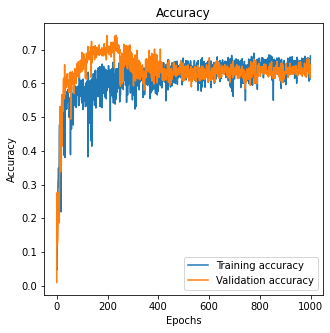

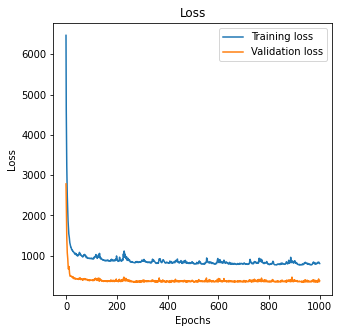

In [ ]:
# Extract the accuracy and loss values from the history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the first graph in the first subplot
fig = plt.figure(figsize=(5, 5))
plt.plot(acc, label='Training accuracy')
plt.plot(val_acc, label='Validation accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot the second graph in the second subplot
fig = plt.figure(figsize=(5, 5))
plt.plot(loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

2/2 [==============================] - 0s 7ms/step
(64, 64, 64, 31)
(64, 64, 64, 31)


<function matplotlib.pyplot.show(*args, **kw)>

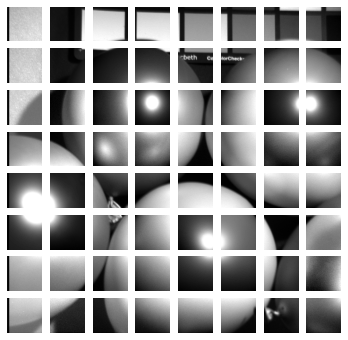

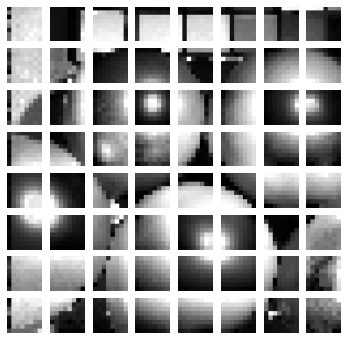

In [ ]:
out6=model.predict([HR_RGB,LRHSI])
patches=np.asarray(gt_data)
print(patches.shape)
plt.figure(figsize=(6,6))
for i in range(64):
  plt.subplot(8,8,i+1)
  plt.imshow(patches[i,:,:,1],cmap='gray')
  plt.axis('off')
plt.show

patches=np.asarray(out6)
print(patches.shape)
plt.figure(figsize=(6,6))
for i in range(64):
  plt.subplot(8,8,i+1)
  plt.imshow(patches[i,:,:,1],cmap='gray')
  plt.axis('off')
plt.show


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
input_layer1 = layers.Input(shape=(64, 64, 3))
input_layer2 = layers.Input(shape=(8, 8, 31))
upsample1 = layers.UpSampling2D(size=1)(input_layer1)
conv_layer1 = layers.Conv2D(64, kernel_size=1, activation='relu')(upsample1)
output_layer1 = layers.Conv2D(31, kernel_size=1, activation='relu')(conv_layer1)
upsample2 = layers.UpSampling2D(size=8)(input_layer2)
conv_layer2 = layers.Conv2D(64, kernel_size=1, activation='relu')(upsample2)
output_layer2 = layers.Conv2D(31, kernel_size=1, activation='relu')(conv_layer2)
concatenated = layers.Concatenate()([output_layer1, output_layer2])
upsample3 = layers.UpSampling2D(size=1)(concatenated)
concatenated1 = layers.Conv2D(31, kernel_size=1, activation='relu')(upsample3)
conv_layer3 = layers.Conv2D(31, kernel_size=1, activation='relu')(concatenated1)
model= tf.keras.Model([input_layer1, input_layer2], conv_layer3)

# Compile the model 
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mean_absolute_error', metrics=['accuracy'])
history = model.fit([HR_RGB, LRHSI], image_transposed, epochs=1000, batch_size=None, validation_split=0.2, steps_per_epoch=12)

Epoch 1/1000
12/12 [==============================] - 1s 40ms/step - loss: 6140.6221 - accuracy: 0.0153 - val_loss: 2400.7517 - val_accuracy: 0.3104
Epoch 2/1000
12/12 [==============================] - 0s 8ms/step - loss: 4195.2856 - accuracy: 0.1241 - val_loss: 1458.4943 - val_accuracy: 9.0144e-04
Epoch 3/1000
12/12 [==============================] - 0s 9ms/step - loss: 2437.1731 - accuracy: 0.0647 - val_loss: 1130.2141 - val_accuracy: 0.2693
Epoch 4/1000
12/12 [==============================] - 0s 8ms/step - loss: 1943.6002 - accuracy: 0.2562 - val_loss: 808.6412 - val_accuracy: 0.3659
Epoch 5/1000
12/12 [==============================] - 0s 8ms/step - loss: 1481.6461 - accuracy: 0.2507 - val_loss: 703.9869 - val_accuracy: 0.0229
Epoch 6/1000
12/12 [==============================] - 0s 11ms/step - loss: 1518.8132 - accuracy: 0.3805 - val_loss: 833.9766 - val_accuracy: 0.0025
Epoch 7/1000
12/12 [==============================] - 0s 8ms/step - loss: 1576.2208 - accuracy: 0.2717 - val_

12/12 [==============================] - 0s 12ms/step - loss: 664.7690 - accuracy: 0.7465 - val_loss: 359.2193 - val_accuracy: 0.6143


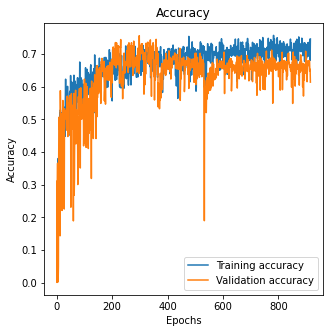

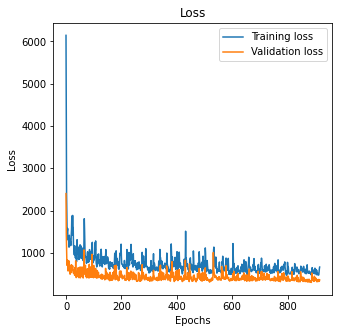

In [ ]:
# Extract the accuracy and loss values from the history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the first graph in the first subplot
fig = plt.figure(figsize=(5, 5))
plt.plot(acc, label='Training accuracy')
plt.plot(val_acc, label='Validation accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot the second graph in the second subplot
fig = plt.figure(figsize=(5, 5))
plt.plot(loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

2/2 [==============================] - 0s 7ms/step
(64, 64, 64, 31)
(64, 64, 64, 31)


<function matplotlib.pyplot.show(*args, **kw)>

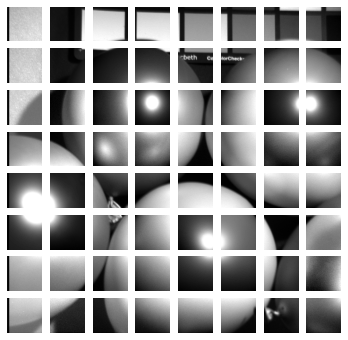

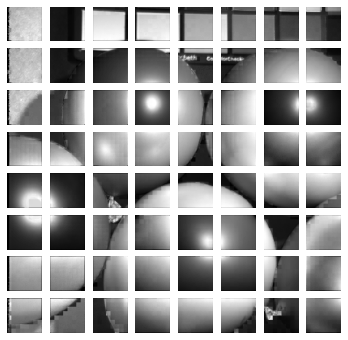

In [ ]:
out6=model.predict([HR_RGB,LRHSI])
patches=np.asarray(gt_data)
print(patches.shape)
plt.figure(figsize=(6,6))
for i in range(64):
  plt.subplot(8,8,i+1)
  plt.imshow(patches[i,:,:,1],cmap='gray')
  plt.axis('off')
plt.show

patches=np.asarray(out6)
print(patches.shape)
plt.figure(figsize=(6,6))
for i in range(64):
  plt.subplot(8,8,i+1)
  plt.imshow(patches[i,:,:,1],cmap='gray')
  plt.axis('off')
plt.show


**normalise dataset before input to the model**

In [ ]:
a=HR_RGB/255
b=LRHSI/255
c=image_transposed/255
print(a.shape)
print(b.shape)
print(c.shape)

(64, 64, 64, 3)
(64, 8, 8, 31)
(64, 64, 64, 31)


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

# Define the input layers
input_layer1 = layers.Input(shape=(64, 64, 3))
input_layer2 = layers.Input(shape=(8, 8, 31))
upsample1 = layers.UpSampling2D(size=1)(input_layer1)
conv_layer1 = layers.Conv2D(64, kernel_size=1, activation='relu')(upsample1)
output_layer1 = layers.Conv2D(31, kernel_size=1, activation='relu')(conv_layer1)
upsample2 = layers.UpSampling2D(size=8)(input_layer2)
conv_layer2 = layers.Conv2D(64, kernel_size=1, activation='relu')(upsample2)
output_layer2 = layers.Conv2D(31, kernel_size=1, activation='relu')(conv_layer2)
concatenated = layers.Concatenate()([output_layer1, output_layer2])
upsample3 = layers.UpSampling2D(size=1)(concatenated)
concatenated1 = layers.Conv2D(31, kernel_size=1, activation='relu')(upsample3)
conv_layer3 = layers.Conv2D(31, kernel_size=1, activation='relu')(concatenated1)
model= tf.keras.Model([input_layer1, input_layer2], conv_layer3)

# Compile the model 
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mean_absolute_error', metrics=['accuracy'])
history = model.fit([a, b], c, epochs=1000, batch_size=None, validation_split=0.2, steps_per_epoch=32)

Epoch 1/1000
32/32 [==============================] - 1s 17ms/step - loss: 22.7726 - accuracy: 0.0228 - val_loss: 7.1257 - val_accuracy: 0.0436
Epoch 2/1000
32/32 [==============================] - 0s 9ms/step - loss: 16.1795 - accuracy: 0.1103 - val_loss: 4.5017 - val_accuracy: 0.0346
Epoch 3/1000
32/32 [==============================] - 0s 9ms/step - loss: 13.0577 - accuracy: 0.1870 - val_loss: 4.6015 - val_accuracy: 0.0066
Epoch 4/1000
32/32 [==============================] - 0s 9ms/step - loss: 9.4899 - accuracy: 0.1929 - val_loss: 10.2461 - val_accuracy: 9.3900e-04
Epoch 5/1000
32/32 [==============================] - 0s 9ms/step - loss: 8.2658 - accuracy: 0.1289 - val_loss: 2.9729 - val_accuracy: 0.0045
Epoch 6/1000
32/32 [==============================] - 0s 6ms/step - loss: 6.5407 - accuracy: 0.2210 - val_loss: 2.7090 - val_accuracy: 0.3597
Epoch 7/1000
32/32 [==============================] - 0s 6ms/step - loss: 6.4934 - accuracy: 0.2372 - val_loss: 2.4236 - val_accuracy: 0.01

32/32 [==============================] - 0s 5ms/step - loss: 2.8186 - accuracy: 0.7097 - val_loss: 1.5117 - val_accuracy: 0.7436


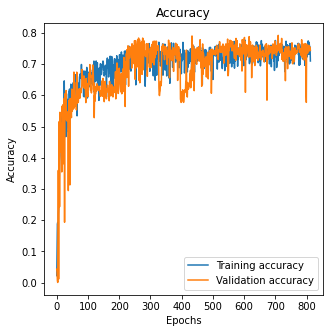

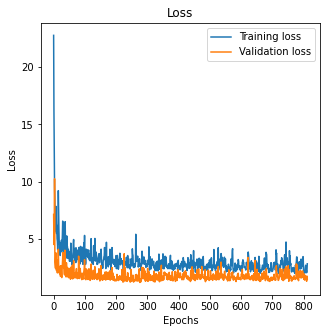

In [ ]:
# Extract the accuracy and loss values from the history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the first graph in the first subplot
fig = plt.figure(figsize=(5, 5))
plt.plot(acc, label='Training accuracy')
plt.plot(val_acc, label='Validation accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot the second graph in the second subplot
fig = plt.figure(figsize=(5, 5))
plt.plot(loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

2/2 [==============================] - 0s 9ms/step
(64, 64, 64, 31)
(64, 64, 64, 31)


<function matplotlib.pyplot.show(*args, **kw)>

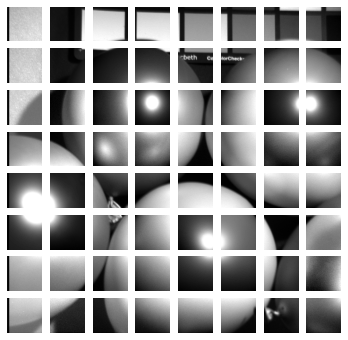

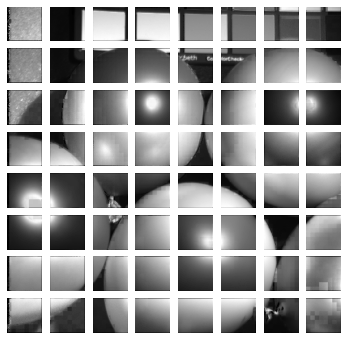

In [ ]:
out6=model.predict([HR_RGB,LRHSI])
patches=np.asarray(gt_data)
print(patches.shape)
plt.figure(figsize=(6,6))
for i in range(64):
  plt.subplot(8,8,i+1)
  plt.imshow(patches[i,:,:,1],cmap='gray')
  plt.axis('off')
plt.show

patches=np.asarray(out6)
print(patches.shape)
plt.figure(figsize=(6,6))
for i in range(64):
  plt.subplot(8,8,i+1)
  plt.imshow(patches[i,:,:,1],cmap='gray')
  plt.axis('off')
plt.show


**TO IMPROVE THE MODEL FURTHER , I DECIDED TO ADD MORE CONVOLUTIONAL AND POOLING LAYERS**

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

# Define the input layers
input_layer1 = layers.Input(shape=(64, 64, 3))
input_layer2 = layers.Input(shape=(8, 8, 31))
upsample1 = layers.UpSampling2D(size=1)(input_layer1)
conv_layer1 = layers.Conv2D(64, kernel_size=1, activation='relu')(upsample1)
output_layer1 = layers.Conv2D(31, kernel_size=1, activation='relu')(conv_layer1)
upsample2 = layers.UpSampling2D(size=2)(input_layer2)
upsample3 = layers.UpSampling2D(size=2)(upsample2)
upsample4 = layers.UpSampling2D(size=2)(upsample3)
upsample5 = layers.UpSampling2D(size=2)(upsample4)
conv_layer2 = layers.Conv2D(31, kernel_size=8, activation='relu')(upsample5)
output_layer2 = layers.Conv2D(31, kernel_size=8, activation='relu')(conv_layer2)
output_layer3 = layers.Conv2D(31, kernel_size=8, activation='relu')(output_layer2)
output_layer4 = layers.Conv2D(31, kernel_size=8, activation='relu')(output_layer3)
output_layer5 = layers.Conv2D(31, kernel_size=8, activation='relu')(output_layer4)
output_layer6 = layers.Conv2D(31, kernel_size=8, activation='relu')(output_layer5)
output_layer7 = layers.Conv2D(31, kernel_size=8, activation='relu')(output_layer6)
output_layer8 = layers.Conv2D(31, kernel_size=8, activation='relu')(output_layer7)
output_layer9 = layers.Conv2D(31, kernel_size=8, activation='relu')(output_layer8)
output_layer10 = layers.Conv2D(31, kernel_size=2, activation='relu')(output_layer9)
concatenated = layers.Concatenate()([output_layer1, output_layer10])
conv_layer3 = layers.Conv2D(31, kernel_size=1, activation='relu')(concatenated)
max_pool_layer1 = layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='same')(conv_layer3)
max_pool_layer2 = layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='same')(max_pool_layer1)
max_pool_layer3 = layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='same')(max_pool_layer2)
model_imp = tf.keras.Model([input_layer1, input_layer2], max_pool_layer3)

# Compile the model
model_imp.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mean_absolute_error', metrics=['accuracy'])
history = model_imp.fit([a, b], c, epochs=1000, batch_size=32, validation_split=0.2)

Epoch 1/1000
2/2 [==============================] - 8s 3s/step - loss: 2244299520.0000 - accuracy: 0.0012 - val_loss: 617.4838 - val_accuracy: 1.1268e-04
Epoch 2/1000
2/2 [==============================] - 0s 147ms/step - loss: 1232.1587 - accuracy: 0.0027 - val_loss: 14.8200 - val_accuracy: 3.3804e-04
Epoch 3/1000
2/2 [==============================] - 0s 182ms/step - loss: 34.9232 - accuracy: 0.0013 - val_loss: 12.9225 - val_accuracy: 2.0658e-04
Epoch 4/1000
2/2 [==============================] - 0s 145ms/step - loss: 30.8210 - accuracy: 0.0032 - val_loss: 12.0750 - val_accuracy: 0.0027
Epoch 5/1000
2/2 [==============================] - 0s 143ms/step - loss: 28.0526 - accuracy: 0.0016 - val_loss: 13.7582 - val_accuracy: 0.0027
Epoch 6/1000
2/2 [==============================] - 0s 183ms/step - loss: 27.6658 - accuracy: 0.0030 - val_loss: 13.3968 - val_accuracy: 0.0026
Epoch 7/1000
2/2 [==============================] - 0s 144ms/step - loss: 25.9281 - accuracy: 0.0015 - val_loss: 12.

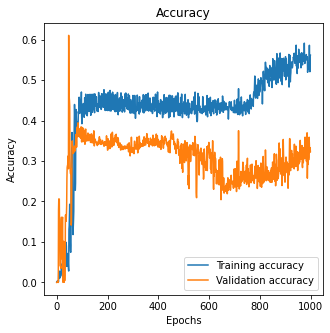

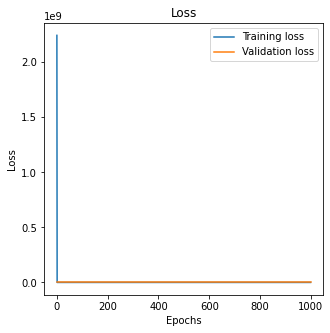

In [ ]:
# Extract the accuracy and loss values from the history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the first graph in the first subplot
fig = plt.figure(figsize=(5, 5))
plt.plot(acc, label='Training accuracy')
plt.plot(val_acc, label='Validation accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot the second graph in the second subplot
fig = plt.figure(figsize=(5, 5))
plt.plot(loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

2/2 [==============================] - 0s 43ms/step
(64, 64, 64, 31)
(64, 64, 64, 31)


<function matplotlib.pyplot.show(*args, **kw)>

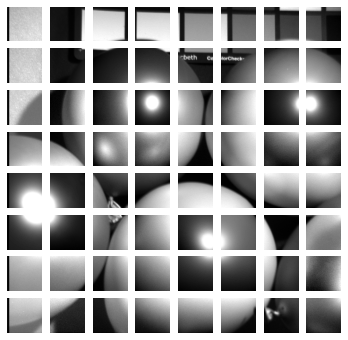

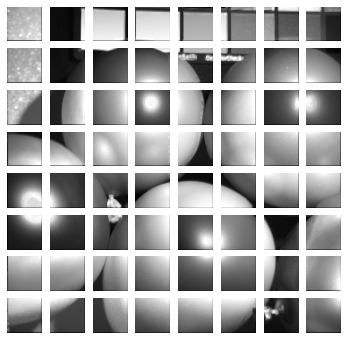

In [ ]:
out7=model_imp.predict([HR_RGB,LRHSI])
patches=np.asarray(gt_data)
print(patches.shape)
plt.figure(figsize=(6,6))
for i in range(64):
  plt.subplot(8,8,i+1)
  plt.imshow(patches[i,:,:,1],cmap='gray')
  plt.axis('off')
plt.show
out7=out7*255
patches=np.asarray(out7)
print(patches.shape)
plt.figure(figsize=(6,6))
for i in range(64):
  plt.subplot(8,8,i+1)
  plt.imshow(patches[i,:,:,1],cmap='gray')
  plt.axis('off')
plt.show
